# Hydrologic forecast with LSTM on HYSETS

This notebook contains steps for developing LSTM modeel for streamflow estimation in Southeast Atlantic and Northwest Pacific Region. The watersheds are shown in Figure below

![alt text](../extent.png)

In [2]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import joblib
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [4]:
# Prepare the sequences - sequence_length is the past window size, y contains next day value as target
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):

        # Skip if streamflow value is NaN
        if not np.isnan(target[i:i+sequence_length+1]).any():

            X.append(features[i:i+sequence_length])
            y.append(target[i+sequence_length])

    return np.array(X), np.array(y)

## Atlantic Watersheds

### Feature Scaling in Train Set

In [ ]:
#Change folder path if needed
folder = 'atlantic_train'

folder_path = 'data/' + folder

i = 0
# Walk through the subfolder
for root, dirs, files in os.walk(folder_path):

    for file in files:
        i += 1
        file_path = os.path.join(folder_path, file)
        print(file_path)

        df = pd.read_csv(file_path)
        non_nan_cnt = df['streamflow'].notna().sum()
        #print(non_nan_cnt)

        features = df.dropna(subset=['streamflow']).copy(deep=True)

        if i == 1:
            X_features = features.copy(deep=True)
        else:
            X_features = pd.concat([X_features, features])

data/atlantic_train/hysets_02423500.csv
data/atlantic_train/hysets_02415000.csv
data/atlantic_train/hysets_02353500.csv
data/atlantic_train/hysets_02401000.csv
data/atlantic_train/hysets_02231000.csv
data/atlantic_train/hysets_02191300.csv
data/atlantic_train/hysets_02359500.csv
data/atlantic_train/hysets_02368500.csv
data/atlantic_train/hysets_02371500.csv
data/atlantic_train/hysets_02367006.csv
data/atlantic_train/hysets_02424940.csv
data/atlantic_train/hysets_02195320.csv
data/atlantic_train/hysets_02398000.csv
data/atlantic_train/hysets_03568933.csv
data/atlantic_train/hysets_02369000.csv
data/atlantic_train/hysets_02413300.csv
data/atlantic_train/hysets_02419000.csv
data/atlantic_train/hysets_02326500.csv
data/atlantic_train/hysets_02329600.csv
data/atlantic_train/hysets_02373000.csv
data/atlantic_train/hysets_02407514.csv
data/atlantic_train/hysets_02392780.csv
data/atlantic_train/hysets_02204520.csv
data/atlantic_train/hysets_02203000.csv
data/atlantic_train/hysets_02408540.csv


In [6]:
X_features.shape

(947496, 33)

In [7]:
X_features.head()

,Year sin,Year cos,snow_depth_water_equivalent_mean,surface_net_solar_radiation_mean,surface_net_thermal_radiation_mean,surface_pressure_mean,temperature_2m_mean,dewpoint_temperature_2m_mean,u_component_of_wind_10m_mean,v_component_of_wind_10m_mean,...,Land_Use_Grass_frac,Land_Use_Wetland_frac,Land_Use_Water_frac,Land_Use_Urban_frac,Land_Use_Shrubs_frac,Land_Use_Crops_frac,Land_Use_Snow_Ice_frac,Permeability_logk_m2,Porosity_frac,streamflow
1003,-0.999936,-0.011343,0.0,205.70,-87.71,99.30,19.49,12.55,0.42,0.50,...,0.0309,0.006,0.0136,0.3333,0.0266,0.0596,0.0,-14.624387,0.119798,0.04
1004,-0.999983,0.005860,0.0,205.21,-95.47,99.31,20.47,12.66,-0.15,1.07,...,0.0309,0.006,0.0136,0.3333,0.0266,0.0596,0.0,-14.624387,0.119798,0.04
1005,-0.999734,0.023060,0.0,192.14,-80.42,99.13,21.78,14.94,0.11,1.87,...,0.0309,0.006,0.0136,0.3333,0.0266,0.0596,0.0,-14.624387,0.119798,0.04
1006,-0.999189,0.040254,0.0,101.32,-39.64,98.79,22.21,19.38,0.72,1.91,...,0.0309,0.006,0.0136,0.3333,0.0266,0.0596,0.0,-14.624387,0.119798,0.04
1007,-0.998349,0.057436,0.0,137.96,-49.80,98.73,22.04,16.35,2.01,0.14,...,0.0309,0.006,0.0136,0.3333,0.0266,0.0596,0.0,-14.624387,0.119798,0.04


In [ ]:
# Fit StandardScaler to training data
atlantic_scaler = StandardScaler()
atlantic_scaler.fit(X_features)

# Save the 'StandardScaler'
joblib.dump(atlantic_scaler, 'atlantic_standardscaler.joblib')

['atlantic_standardscaler.joblib']

### Gather train and validation set from the Atlantic Set

In [9]:
# First gather the train set
folder = 'atlantic_train'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

X_full_data_list = []
y_full_data_list = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        print('Appending', file_path)
        df = pd.read_csv(file_path)

        if df['streamflow'].notna().sum() > seq_length:
            target = df['streamflow'].to_numpy()  # Target remains the 'streamflow'
            # Retain 'streamflow' in the features set
            features_scaled = atlantic_scaler.transform(df)
            #features_scaled = df
            X, y = create_sequences(features_scaled, target, seq_length)
            X_full_data_list.append(X)
            y_full_data_list.append(y)

# Concatenate all data from list to a single numpy array
X_full_data = np.concatenate(X_full_data_list, axis=0)
y_full_data = np.concatenate(y_full_data_list, axis=0)

# Preparing tensors for PyTorch
X_train = torch.tensor(X_full_data, dtype=torch.float32)
y_train = torch.tensor(y_full_data, dtype=torch.float32)

Appending data/atlantic_train/hysets_02423500.csv
Appending data/atlantic_train/hysets_02415000.csv
Appending data/atlantic_train/hysets_02353500.csv
Appending data/atlantic_train/hysets_02401000.csv
Appending data/atlantic_train/hysets_02231000.csv
Appending data/atlantic_train/hysets_02191300.csv
Appending data/atlantic_train/hysets_02359500.csv
Appending data/atlantic_train/hysets_02368500.csv
Appending data/atlantic_train/hysets_02371500.csv
Appending data/atlantic_train/hysets_02367006.csv
Appending data/atlantic_train/hysets_02424940.csv
Appending data/atlantic_train/hysets_02195320.csv
Appending data/atlantic_train/hysets_02398000.csv
Appending data/atlantic_train/hysets_03568933.csv
Appending data/atlantic_train/hysets_02369000.csv
Appending data/atlantic_train/hysets_02413300.csv
Appending data/atlantic_train/hysets_02419000.csv
Appending data/atlantic_train/hysets_02326500.csv
Appending data/atlantic_train/hysets_02329600.csv
Appending data/atlantic_train/hysets_02373000.csv


In [ ]:
# Verifying the shape and content
X_train.shape

torch.Size([945997, 5, 33])

In [11]:

y_train.shape

torch.Size([945997])

In [12]:
X_train[0]

tensor([[-1.4092, -0.0157, -0.0731,  0.6550, -1.0752, -0.2494,  0.2016,  0.0330,
          0.2278,  0.3170, -0.6208, -0.3360, -0.3961,  0.1178, -0.4414,  0.7115,
         -0.4171,  0.3663,  1.0789,  1.1836,  0.0900, -0.3827,  0.4221, -0.5602,
         -0.8083,  0.4518,  1.2485, -0.8064, -0.8603,  0.0000, -1.4100, -0.2123,
         -0.5173],
        [-1.4093,  0.0086, -0.0731,  0.6477, -1.3668, -0.2429,  0.3282,  0.0458,
         -0.1498,  0.7210, -0.7253, -0.3360, -0.3961,  0.1178, -0.4414,  0.9013,
         -0.4171,  0.3663,  1.0789,  1.1836,  0.0900, -0.3827,  0.4221, -0.5602,
         -0.8083,  0.4518,  1.2485, -0.8064, -0.8603,  0.0000, -1.4100, -0.2123,
         -0.5173],
        [-1.4090,  0.0329, -0.0731,  0.4514, -0.8013, -0.3605,  0.4973,  0.3105,
          0.0224,  1.2880, -0.8298, -0.4410, -0.3961,  0.1178, -0.4414,  0.7069,
         -0.4171,  0.3663,  1.0789,  1.1836,  0.0900, -0.3827,  0.4221, -0.5602,
         -0.8083,  0.4518,  1.2485, -0.8064, -0.8603,  0.0000, -1.4100,

In [13]:
y_train[0:10]

tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.1400, 0.1400, 0.1400, 0.1400,
        0.1400])

In [ ]:
# First gather the val set
folder = 'atlantic_val'
folder_path = f'data/{folder}'

X_full_data_list = []
y_full_data_list = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        print('Appending', file_path)
        df = pd.read_csv(file_path)

        if df['streamflow'].notna().sum() > seq_length:
            target = df['streamflow'].to_numpy()  # Target remains the 'streamflow'
            # Retain 'streamflow' in the features set
            #features_scaled = df
            features_scaled = atlantic_scaler.transform(df)
            X, y = create_sequences(features_scaled, target, seq_length)
            X_full_data_list.append(X)
            y_full_data_list.append(y)

# Concatenate all data from list to a single numpy array
X_full_data = np.concatenate(X_full_data_list, axis=0)
y_full_data = np.concatenate(y_full_data_list, axis=0)

# Preparing tensors for PyTorch
X_val = torch.tensor(X_full_data, dtype=torch.float32)
y_val = torch.tensor(y_full_data, dtype=torch.float32)

Appending data/atlantic_val/hysets_02198690.csv
Appending data/atlantic_val/hysets_02331000.csv
Appending data/atlantic_val/hysets_02208450.csv
Appending data/atlantic_val/hysets_02350600.csv
Appending data/atlantic_val/hysets_02359500.csv
Appending data/atlantic_val/hysets_02316000.csv
Appending data/atlantic_val/hysets_02206500.csv
Appending data/atlantic_val/hysets_02339495.csv
Appending data/atlantic_val/hysets_02202600.csv
Appending data/atlantic_val/hysets_02209000.csv
Appending data/atlantic_val/hysets_02462000.csv
Appending data/atlantic_val/hysets_02217615.csv
Appending data/atlantic_val/hysets_02365470.csv
Appending data/atlantic_val/hysets_02374500.csv
Appending data/atlantic_val/hysets_02403395.csv
Appending data/atlantic_val/hysets_02450180.csv
Appending data/atlantic_val/hysets_02404400.csv
Appending data/atlantic_val/hysets_02344700.csv
Appending data/atlantic_val/hysets_02369800.csv
Appending data/atlantic_val/hysets_02227270.csv
Appending data/atlantic_val/hysets_02354

In [15]:
X_val.shape, y_val.shape

(torch.Size([229938, 5, 33]), torch.Size([229938]))

In [16]:
X_val[0]

tensor([[ 1.2141,  0.7345, -0.0731,  0.4315, -0.9189,  1.6311, -0.7060, -0.5312,
         -0.5739, -0.1862, -1.4569, -1.3859, -1.3282, -1.4811, -0.4348, -0.0696,
         -0.8028, -1.1449, -0.8623, -0.4699, -0.8469, -1.4490, -1.1416, -0.0473,
          2.0855, -0.4849, -0.5309,  0.4890, -0.0567,  0.0000,  1.4331,  1.2176,
          0.4875],
        [ 1.2265,  0.7136, -0.0731, -1.4553,  0.7498,  1.1414, -0.5162,  0.0493,
         -0.9581,  0.6714, -1.4569, -1.3859, -1.4318, -1.4811, -0.0293, -1.3679,
         -0.8028, -1.1449, -0.8623, -0.4699, -0.8469, -1.4490, -1.1416, -0.0473,
          2.0855, -0.4849, -0.5309,  0.4890, -0.0567,  0.0000,  1.4331,  1.2176,
          0.4208],
        [ 1.2386,  0.6925, -0.0731, -0.9907,  1.1680,  0.5537, -0.3109,  0.0052,
          1.2812,  0.2603, -1.0389, -1.3859, -1.4318, -1.4811,  0.1259, -0.4456,
         -0.8028, -1.1449, -0.8623, -0.4699, -0.8469, -1.4490, -1.1416, -0.0473,
          2.0855, -0.4849, -0.5309,  0.4890, -0.0567,  0.0000,  1.4331,

In [17]:
y_val[0]

tensor(0.8500)

In [18]:
y_val.mean(), y_val.std(), y_val.max(), y_val.min()

(tensor(1.3118), tensor(2.5197), tensor(172.3400), tensor(0.))

### Model Setup and Training

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer with dropout between layers if more than one layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

        # Define dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Apply dropout to the outputs of the last LSTM layer
        out = self.dropout(out[:, -1, :])

        # Pass through the output layer
        out = self.linear(out)
        return out


In [20]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        torch.save(model.state_dict(), '2nd/atlantic_checkpoint.pt')
        self.val_loss_min = val_loss


In [46]:
train_losses = []
val_losses = []

def train_model(model, train_loader, validate_loader, epochs, early_stopping):
    model.train()

    for epoch in range(epochs):
        print('epoch:', epoch+1)
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        validation_loss = 0
        with torch.no_grad():
            for inputs, labels in validate_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1))
                validation_loss += loss.item()

        avg_val_loss = validation_loss / len(validate_loader)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

        # Call early stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        model.train()  # Reset to training mode

    return train_losses, val_losses


In [ ]:
#Batching
from torch.utils.data import TensorDataset, DataLoader

batch_size = 256

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validate_dataset = TensorDataset(X_val, y_val)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)


In [73]:
# Initialize the model
model_atlantic = LSTMModel(input_dim=33, hidden_dim=64, num_layers=1, output_dim=1, dropout = 0.25)
model_atlantic = model_atlantic.to(device)
print(model_atlantic)
# Loss and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_atlantic.parameters(), lr=0.0015)

LSTMModel(
  (lstm): LSTM(33, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [74]:
early_stopping = EarlyStopping(patience=5, verbose=True)  # Adjust patience as needed
train_losses = []
val_losses = []
train_losses, val_losses = train_model(model_atlantic, train_loader, validate_loader, 50, early_stopping)  # 50 epochs as an example


epoch: 1
Epoch 1/50, Training Loss: 2.0992276691992915, Validation Loss: 2.1736165344781417
Validation loss decreased (inf --> 2.173617).  Saving model...
epoch: 2
Epoch 2/50, Training Loss: 1.743970458665903, Validation Loss: 2.070426990411703
Validation loss decreased (2.173617 --> 2.070427).  Saving model...
epoch: 3
Epoch 3/50, Training Loss: 1.657746523699332, Validation Loss: 2.0042594567985503
Validation loss decreased (2.070427 --> 2.004259).  Saving model...
epoch: 4
Epoch 4/50, Training Loss: 1.6049105251526452, Validation Loss: 2.0268686299064136
EarlyStopping counter: 1 out of 5
epoch: 5
Epoch 5/50, Training Loss: 1.5560922944672342, Validation Loss: 1.968023962518397
Validation loss decreased (2.004259 --> 1.968024).  Saving model...
epoch: 6
Epoch 6/50, Training Loss: 1.5207319238678718, Validation Loss: 1.944257809692482
Validation loss decreased (1.968024 --> 1.944258).  Saving model...
epoch: 7
Epoch 7/50, Training Loss: 1.4856862564413966, Validation Loss: 1.987425486

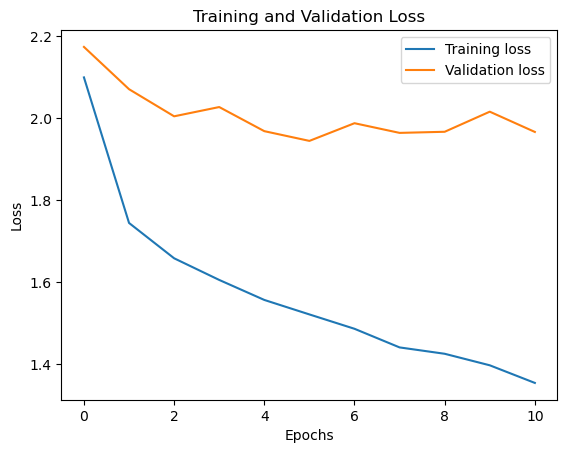

In [75]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [76]:
def calculate_nse(observed, modeled):
    """
    Calculate the Nash-Sutcliffe Efficiency coefficient.

    Args:
    observed (numpy.ndarray): Observed data.
    modeled (numpy.ndarray): Modeled data predicted by the model.

    Returns:
    float: The calculated NSE.
    """
    mean_observed = np.mean(observed)
    numerator = np.sum((modeled - observed) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

In [ ]:
# Load the trained model and the scaler
model_atlantic.load_state_dict(torch.load('2nd/atlantic_checkpoint.pt'))
model_atlantic.eval()  # Set the model to evaluation mode
model_atlantic.to(device)  # Move model to the appropriate device

scaler = joblib.load('atlantic_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'atlantic_val'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

nse_scores = []  # List to store NSE scores for each catchment

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:
            features_scaled = atlantic_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred = model_atlantic(X_tensor).cpu().numpy()

            # Flatten the predictions and observed values
            y_pred = y_pred.flatten()
            y_observed = y_observed.flatten()

            # Calculate NSE for this catchment
            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}")

# Calculate mean NSE across all catchments
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")


Catchment: hysets_02198690.csv, NSE: 0.8606072225895035
Catchment: hysets_02331000.csv, NSE: 0.6808191756807125
Catchment: hysets_02208450.csv, NSE: 0.81413167550579
Catchment: hysets_02350600.csv, NSE: 0.7492281393989425
Catchment: hysets_02359500.csv, NSE: 0.871485584229363
Catchment: hysets_02316000.csv, NSE: 0.9521986806570012
Catchment: hysets_02206500.csv, NSE: 0.5983538047405134
Catchment: hysets_02339495.csv, NSE: 0.7084479395808385
Catchment: hysets_02202600.csv, NSE: 0.9035008921542333
Catchment: hysets_02209000.csv, NSE: 0.8697348118893637
Catchment: hysets_02462000.csv, NSE: 0.5072858890825452
Catchment: hysets_02217615.csv, NSE: 0.34352094863825
Catchment: hysets_02365470.csv, NSE: 0.8035744077328472
Catchment: hysets_02374500.csv, NSE: 0.759425106337262
Catchment: hysets_02403395.csv, NSE: 0.7755388424079384
Catchment: hysets_02450180.csv, NSE: 0.7379328490500341
Catchment: hysets_02404400.csv, NSE: 0.6971357354240436
Catchment: hysets_02344700.csv, NSE: 0.661000057604466

### Test set

This section includes the testing of Atlantic model on the two test set. 

Test set (Unseen) includes catchment data that are in the same region, but unseen by the model. 

Test set (Seen) includes catchment data in which first 75% was used to train/ val the model, the latter 25% was placed in this test set.

#### Test set (Unseen)

In [ ]:
# Load the trained model and the scaler
model_atlantic.load_state_dict(torch.load('2nd/atlantic_checkpoint.pt'))
model_atlantic.eval()  # Set the model to evaluation mode
model_atlantic.to(device)  # Move model to the appropriate device

scaler = joblib.load('atlantic_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'atlantic_test'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

test_losses = []
nse_scores = []  # List to store NSE scores for each catchment

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:
            features_scaled = atlantic_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_observed, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred_tensor = model_atlantic(X_tensor)
            
            # Calculate Loss using tensors directly
            loss = criterion(y_pred_tensor, y_tensor.view(-1, 1))  # Ensure y_tensor is correctly shaped
            test_losses.append(loss.item())

            # Calculate NSE if needed, convert tensors to numpy arrays outside of loss calculation
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_observed = y_tensor.cpu().numpy()

            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}, Loss: {loss.item()}")

# Calculate mean NSE across all catchments
mean_loss = np.mean(test_losses)
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")
print(f"Mean Loss all catchments: {mean_loss}")


Catchment: hysets_02353265.csv, NSE: 0.8688388019800186, Loss: 0.2155076414346695
Catchment: hysets_02370000.csv, NSE: 0.7391250431537628, Loss: 2.109788656234741
Catchment: hysets_02413000.csv, NSE: 0.8167929649353027, Loss: 1.0445924997329712
Catchment: hysets_02374700.csv, NSE: 0.8367347419261932, Loss: 0.5865681171417236
Catchment: hysets_02207448.csv, NSE: 0.7878416627645493, Loss: 0.6487824320793152
Catchment: hysets_03567500.csv, NSE: 0.8440678864717484, Loss: 1.382677674293518
Catchment: hysets_02220900.csv, NSE: 0.7627353519201279, Loss: 0.6174827814102173
Catchment: hysets_02329500.csv, NSE: 0.7156976759433746, Loss: 1.4734307527542114
Catchment: hysets_02331600.csv, NSE: 0.6285361647605896, Loss: 1.4313371181488037
Catchment: hysets_02427250.csv, NSE: 0.6992542743682861, Loss: 3.0256617069244385
Catchment: hysets_02338660.csv, NSE: 0.749196857213974, Loss: 0.9309847950935364
Catchment: hysets_02344500.csv, NSE: 0.8150762170553207, Loss: 0.8687039017677307
Catchment: hysets_0

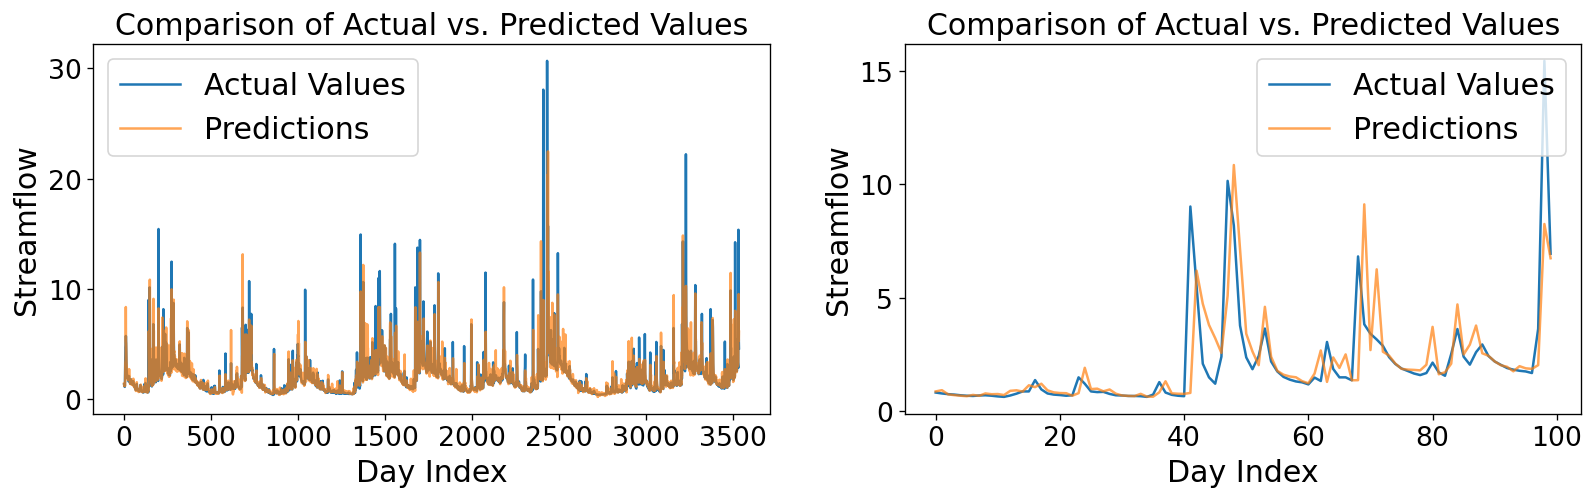

In [87]:
# Create a figure and a subplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=120)

# Plot the lines
ax[0].plot(y_observed, label='Actual Values')
ax[0].plot(y_pred, label='Predictions', alpha=0.7)
ax[1].plot(y_observed[100:200], label='Actual Values')
ax[1].plot(y_pred[100:200], label='Predictions', alpha=0.7)

# Add labels and title
ax[0].set_xlabel('Day Index')
ax[0].set_ylabel('Streamflow')
ax[0].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)
ax[1].set_xlabel('Day Index')
ax[1].set_ylabel('Streamflow')
ax[1].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)

# Set the fontsize for axis labels
ax[0].xaxis.label.set_fontsize(18)
ax[0].yaxis.label.set_fontsize(18)
ax[1].xaxis.label.set_fontsize(18)
ax[1].yaxis.label.set_fontsize(18)

# Increase the size of xticks and yticks
ax[0].tick_params(axis='both', which='both', labelsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=16)

# Add legend and set fontsize
ax[0].legend(fontsize=18, loc='upper left')
ax[1].legend(fontsize=18, loc='upper right')

# Show the plot
plt.savefig('atlantic_compare_15.png', format='png', dpi=300)
plt.show()

#### Test set (Future data of the same HYSETS)

In [ ]:
# Load the trained model and the scaler
model_atlantic.load_state_dict(torch.load('2nd/atlantic_checkpoint.pt'))
model_atlantic.eval()  # Set the model to evaluation mode
model_atlantic.to(device)  # Move model to the appropriate device

scaler = joblib.load('atlantic_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'atlantic_test_same_hysets'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

test_losses = []
nse_scores = []  # List to store NSE scores for each catchment

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:
            features_scaled = atlantic_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_observed, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred_tensor = model_atlantic(X_tensor)
            
            # Calculate Loss using tensors directly
            loss = criterion(y_pred_tensor, y_tensor.view(-1, 1))  # Ensure y_tensor is correctly shaped
            test_losses.append(loss.item())

            # Calculate NSE if needed, convert tensors to numpy arrays outside of loss calculation
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_observed = y_tensor.cpu().numpy()

            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}, Loss: {loss.item()}")

# Calculate mean NSE across all catchments
mean_loss = np.mean(test_losses)
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")
print(f"Mean Loss all catchments: {mean_loss}")


Catchment: hysets_02401000.csv, NSE: 0.8428685218095779, Loss: 0.8925859928131104
Catchment: hysets_02350600.csv, NSE: 0.8368092626333237, Loss: 0.2197820395231247
Catchment: hysets_02368500.csv, NSE: 0.6809137761592865, Loss: 2.172886371612549
Catchment: hysets_02371500.csv, NSE: 0.9116999506950378, Loss: 0.26582592725753784
Catchment: hysets_02316000.csv, NSE: 0.9467447511851788, Loss: 0.08907342702150345
Catchment: hysets_02195320.csv, NSE: 0.5366585850715637, Loss: 0.6380383372306824
Catchment: hysets_02206500.csv, NSE: 0.5687685608863831, Loss: 4.580225467681885
Catchment: hysets_02318000.csv, NSE: 0.9288514852523804, Loss: 0.28769633173942566
Catchment: hysets_02421000.csv, NSE: 0.8462132811546326, Loss: 1.6769570112228394
Catchment: hysets_02387000.csv, NSE: 0.891670249402523, Loss: 0.8653990626335144
Catchment: hysets_02357150.csv, NSE: 0.9235275387763977, Loss: 0.01795255020260811
Catchment: hysets_02423555.csv, NSE: 0.6875960826873779, Loss: 2.4126663208007812
Catchment: hyse

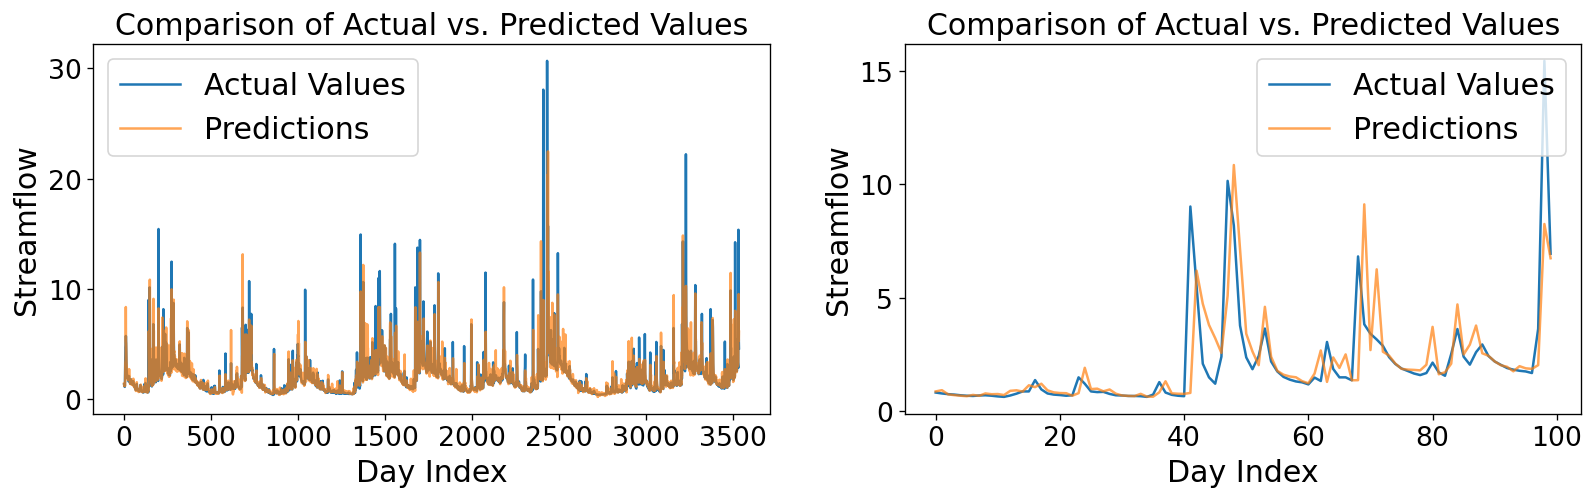

In [ ]:
# Create a figure and a subplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=120)

# Plot the lines
ax[0].plot(y_observed, label='Actual Values')
ax[0].plot(y_pred, label='Predictions', alpha=0.7)
ax[1].plot(y_observed[100:200], label='Actual Values')
ax[1].plot(y_pred[100:200], label='Predictions', alpha=0.7)

# Add labels and title
ax[0].set_xlabel('Day Index')
ax[0].set_ylabel('Streamflow')
ax[0].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)
ax[1].set_xlabel('Day Index')
ax[1].set_ylabel('Streamflow')
ax[1].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)

# Set the fontsize for axis labels
ax[0].xaxis.label.set_fontsize(18)
ax[0].yaxis.label.set_fontsize(18)
ax[1].xaxis.label.set_fontsize(18)
ax[1].yaxis.label.set_fontsize(18)

# Increase the size of xticks and yticks
ax[0].tick_params(axis='both', which='both', labelsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=16)

# Add legend and set fontsize
ax[0].legend(fontsize=18, loc='upper left')
ax[1].legend(fontsize=18, loc='upper right')

# Show the plot
plt.savefig('atlantic_compare_15.png', format='png', dpi=300)
plt.show()

#### Cross watersheds (Using atlantic model on pacific data)

In [ ]:
# Load the trained model and the scaler
model_atlantic.load_state_dict(torch.load('2nd/atlantic_checkpoint.pt'))
model_atlantic.eval()  # Set the model to evaluation mode
model_atlantic.to(device)  # Move model to the appropriate device

scaler = joblib.load('atlantic_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'pacific_test'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

test_losses = []
nse_scores = []  # List to store NSE scores for each catchment

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:
            features_scaled = atlantic_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_observed, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred_tensor = model_atlantic(X_tensor)
            
            # Calculate Loss using tensors directly
            loss = criterion(y_pred_tensor, y_tensor.view(-1, 1))  # Ensure y_tensor is correctly shaped
            test_losses.append(loss.item())

            # Calculate NSE if needed, convert tensors to numpy arrays outside of loss calculation
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_observed = y_tensor.cpu().numpy()

            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}, Loss: {loss.item()}")

# Calculate mean NSE across all catchments
mean_loss = np.mean(test_losses)
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")
print(f"Mean Loss all catchments: {mean_loss}")


Catchment: hysets_12458000.csv, NSE: -0.7856122255325317, Loss: 21.398433685302734
Catchment: hysets_12041200.csv, NSE: 0.5029178261756897, Loss: 54.0693473815918
Catchment: hysets_12447383.csv, NSE: -3.232896327972412, Loss: 27.83590316772461
Catchment: hysets_14118500.csv, NSE: 0.512936145067215, Loss: 12.014235496520996
Catchment: hysets_12026400.csv, NSE: 0.6992574036121368, Loss: 5.344860553741455
Catchment: hysets_08MH147.csv, NSE: 0.15776807069778442, Loss: 92.94551849365234
Catchment: hysets_12080010.csv, NSE: 0.5805691778659821, Loss: 3.477069139480591
Catchment: hysets_12452800.csv, NSE: -3.693253517150879, Loss: 26.703609466552734
Catchment: hysets_08MA003.csv, NSE: -5.087613582611084, Loss: 35.659698486328125
Catchment: hysets_14166500.csv, NSE: 0.6932130455970764, Loss: 4.500748634338379
Catchment: hysets_08MF065.csv, NSE: -0.4492605924606323, Loss: 29.73817253112793
Catchment: hysets_14306400.csv, NSE: 0.24966132640838623, Loss: 30.299762725830078
Catchment: hysets_08LB02

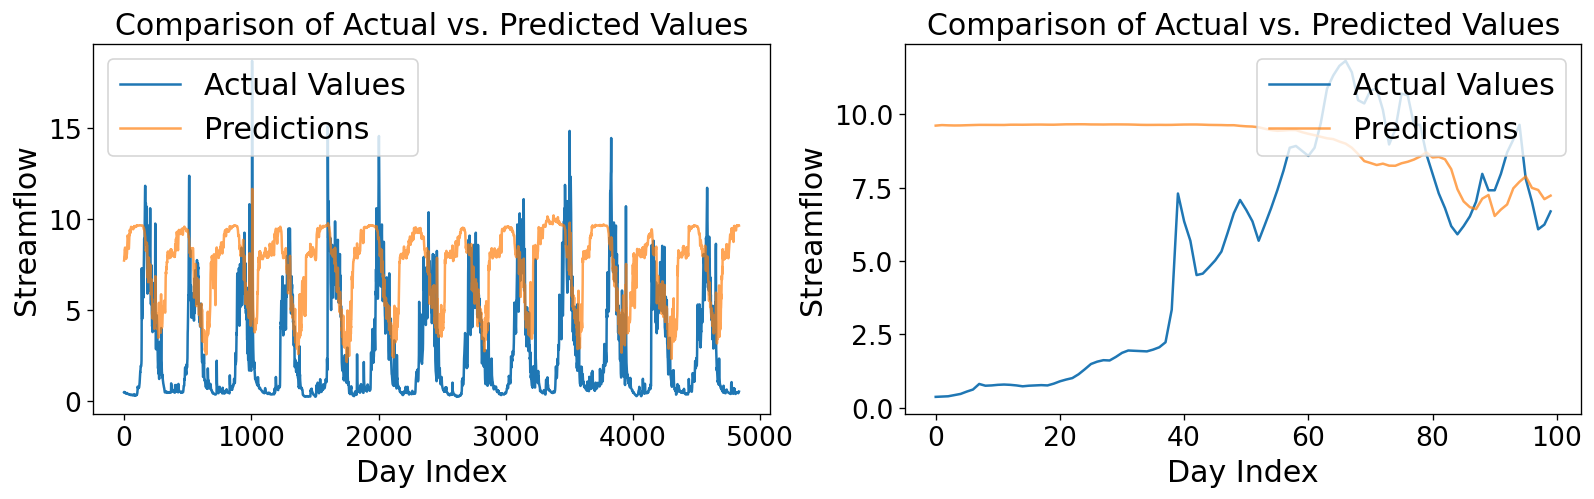

In [113]:
# Create a figure and a subplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=120)

# Plot the lines
ax[0].plot(y_observed, label='Actual Values')
ax[0].plot(y_pred, label='Predictions', alpha=0.7)
ax[1].plot(y_observed[100:200], label='Actual Values')
ax[1].plot(y_pred[100:200], label='Predictions', alpha=0.7)

# Add labels and title
ax[0].set_xlabel('Day Index')
ax[0].set_ylabel('Streamflow')
ax[0].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)
ax[1].set_xlabel('Day Index')
ax[1].set_ylabel('Streamflow')
ax[1].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)

# Set the fontsize for axis labels
ax[0].xaxis.label.set_fontsize(18)
ax[0].yaxis.label.set_fontsize(18)
ax[1].xaxis.label.set_fontsize(18)
ax[1].yaxis.label.set_fontsize(18)

# Increase the size of xticks and yticks
ax[0].tick_params(axis='both', which='both', labelsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=16)

# Add legend and set fontsize
ax[0].legend(fontsize=18, loc='upper left')
ax[1].legend(fontsize=18, loc='upper right')

# Show the plot
plt.savefig('atlantic_compare_15.png', format='png', dpi=300)
plt.show()

The performance of same region predictions are good, with NSE of 0.7 or above. However, the model failed to predict cross regional data.

## Pacific

### Feature Scaling

In [ ]:
# Change folder path as needed
folder = 'pacific_train'

folder_path = 'data/' + folder

i = 0
# Walk through the subfolder
for root, dirs, files in os.walk(folder_path):

    for file in files:
        i += 1
        file_path = os.path.join(folder_path, file)
        print(file_path)

        df = pd.read_csv(file_path)
        non_nan_cnt = df['streamflow'].notna().sum()
        print(non_nan_cnt)

        features = df.dropna(subset=['streamflow']).copy(deep=True)

        if i == 1:
            X_features = features.copy(deep=True)
        else:
            X_features = pd.concat([X_features, features])

data/pacific_train/hysets_12082500.csv
13879
data/pacific_train/hysets_12104500.csv
3953
data/pacific_train/hysets_08NL069.csv
12782
data/pacific_train/hysets_14232500.csv
5528
data/pacific_train/hysets_14185900.csv
13879
data/pacific_train/hysets_14167000.csv
2463
data/pacific_train/hysets_12175500.csv
13879
data/pacific_train/hysets_14241490.csv
5484
data/pacific_train/hysets_12099200.csv
5646
data/pacific_train/hysets_14185000.csv
10956
data/pacific_train/hysets_08ME025.csv
10226
data/pacific_train/hysets_14198500.csv
4655
data/pacific_train/hysets_08MG001.csv
11685
data/pacific_train/hysets_08HF005.csv
7637
data/pacific_train/hysets_08MH001.csv
10562
data/pacific_train/hysets_14190500.csv
10956
data/pacific_train/hysets_14303600.csv
4745
data/pacific_train/hysets_14137000.csv
13879
data/pacific_train/hysets_12448990.csv
1094
data/pacific_train/hysets_12100496.csv
6615
data/pacific_train/hysets_12013500.csv
10956
data/pacific_train/hysets_08ME028.csv
8036
data/pacific_train/hysets_1

In [9]:
X_features.shape

(1039065, 33)

In [10]:
X_features.head()

,Year sin,Year cos,snow_depth_water_equivalent_mean,surface_net_solar_radiation_mean,surface_net_thermal_radiation_mean,surface_pressure_mean,temperature_2m_mean,dewpoint_temperature_2m_mean,u_component_of_wind_10m_mean,v_component_of_wind_10m_mean,...,Land_Use_Grass_frac,Land_Use_Wetland_frac,Land_Use_Water_frac,Land_Use_Urban_frac,Land_Use_Shrubs_frac,Land_Use_Crops_frac,Land_Use_Snow_Ice_frac,Permeability_logk_m2,Porosity_frac,streamflow
0,0.013031,0.999915,34.29,55.58,-64.83,88.09,1.84,0.09,-1.40,0.16,...,0.0588,0.0218,0.0084,0.0322,0.1441,0.0,0.0519,-12.801992,0.119622,9.73
1,0.030229,0.999543,33.54,57.06,-65.14,88.06,0.83,-1.83,-1.55,0.31,...,0.0588,0.0218,0.0084,0.0322,0.1441,0.0,0.0519,-12.801992,0.119622,7.95
2,0.047419,0.998875,33.12,58.05,-74.96,88.10,-0.14,-3.31,-1.45,0.34,...,0.0588,0.0218,0.0084,0.0322,0.1441,0.0,0.0519,-12.801992,0.119622,6.75
3,0.064594,0.997912,32.79,43.06,-39.91,88.60,0.70,-2.67,-0.79,-0.10,...,0.0588,0.0218,0.0084,0.0322,0.1441,0.0,0.0519,-12.801992,0.119622,5.95
4,0.081751,0.996653,32.40,56.23,-56.22,88.37,0.58,-2.18,-1.53,0.28,...,0.0588,0.0218,0.0084,0.0322,0.1441,0.0,0.0519,-12.801992,0.119622,5.35


In [ ]:
# Fit the StandardScaler to Training Data
pacific_scaler = StandardScaler()
pacific_scaler.fit(X_features)

# Save the 'StandardScaler'
joblib.dump(pacific_scaler, 'pacific_standardscaler.joblib')

['pacific_standardscaler.joblib']

### Gather train and val set

In [13]:
# First gather the train set
folder = 'pacific_train'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

X_full_data_list = []
y_full_data_list = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)

        if df['streamflow'].notna().sum() > seq_length:
            target = df['streamflow'].to_numpy()  # Target remains the 'streamflow'
            # Retain 'streamflow' in the features set
            features_scaled = pacific_scaler.transform(df)

            X, y = create_sequences(features_scaled, target, seq_length)
            X_full_data_list.append(X)
            y_full_data_list.append(y)

# Concatenate all data from list to a single numpy array
X_full_data = np.concatenate(X_full_data_list, axis=0)
y_full_data = np.concatenate(y_full_data_list, axis=0)

# Preparing tensors for PyTorch
X_train = torch.tensor(X_full_data, dtype=torch.float32)
y_train = torch.tensor(y_full_data, dtype=torch.float32)

In [14]:
X_train.shape

torch.Size([1037992, 5, 33])

In [15]:
y_train.shape

torch.Size([1037992])

In [16]:
X_train[0]

tensor([[ 0.0217,  1.4167, -0.4087, -0.8110, -0.4930, -0.5565, -0.5036, -0.2372,
         -1.6870, -0.1344,  1.0589,  1.2238,  1.4332,  1.4729, -0.5396, -0.8707,
         -0.7186,  0.4651,  0.2772, -0.7622, -0.8522,  0.2424,  0.1439, -0.4980,
          1.0008,  0.0228, -0.0160, -0.0431, -0.3387,  0.4282,  1.0341,  0.3798,
          0.8976],
        [ 0.0460,  1.4161, -0.4111, -0.7943, -0.5038, -0.5624, -0.6336, -0.5237,
         -1.8390,  0.0416,  0.9358,  1.0936,  1.2829,  1.4729, -0.5396, -0.8073,
         -0.7186,  0.4651,  0.2772, -0.7622, -0.8522,  0.2424,  0.1439, -0.4980,
          1.0008,  0.0228, -0.0160, -0.0431, -0.3387,  0.4282,  1.0341,  0.3798,
          0.6101],
        [ 0.0703,  1.4152, -0.4125, -0.7831, -0.8455, -0.5546, -0.7585, -0.7445,
         -1.7376,  0.0768,  0.8127,  0.9634,  1.1327,  1.4729, -0.5385, -0.8232,
         -0.7186,  0.4651,  0.2772, -0.7622, -0.8522,  0.2424,  0.1439, -0.4980,
          1.0008,  0.0228, -0.0160, -0.0431, -0.3387,  0.4282,  1.0341,

In [17]:
y_train[0:10]

tensor([4.9000, 4.5000, 4.1900, 3.8900, 3.6400, 3.4400, 3.2700, 3.1300, 3.0200,
        2.9100])

In [ ]:
# Gather validation set
folder = 'pacific_val'
folder_path = f'data/{folder}'

X_full_data_list = []
y_full_data_list = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)

        if df['streamflow'].notna().sum() > seq_length:
            target = df['streamflow'].to_numpy()  # Target remains the 'streamflow'
            # Retain 'streamflow' in the features set
            features_scaled = pacific_scaler.transform(df)

            X, y = create_sequences(features_scaled, target, seq_length)
            X_full_data_list.append(X)
            y_full_data_list.append(y)

# Concatenate all data from list to a single numpy array
X_full_data = np.concatenate(X_full_data_list, axis=0)
y_full_data = np.concatenate(y_full_data_list, axis=0)

# Preparing tensors for PyTorch
X_val = torch.tensor(X_full_data, dtype=torch.float32)
y_val = torch.tensor(y_full_data, dtype=torch.float32)

In [19]:
X_val.shape, y_val.shape

(torch.Size([276155, 5, 33]), torch.Size([276155]))

In [20]:
y_val.mean(), y_val.std(), y_val.max(), y_val.min()

(tensor(4.2530), tensor(5.9046), tensor(156.0900), tensor(0.0200))

### Model Setup

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer with dropout between layers if more than one layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

        # Optional: dropout layer applied to the output of the LSTM
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Apply dropout to the outputs of the last LSTM layer
        out = self.dropout(out[:, -1, :])  # Applying dropout to the last time step output

        # Pass through the output layer
        out = self.linear(out)
        return out


In [ ]:
#Batching
from torch.utils.data import TensorDataset, DataLoader

batch_size = 2048

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validate_dataset = TensorDataset(X_val, y_val)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)


In [117]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        torch.save(model.state_dict(), 'pacific_checkpoint_0426.pt')
        self.val_loss_min = val_loss


In [55]:
train_losses = []
val_losses = []

def train_model(model, train_loader, validate_loader, epochs, early_stopping):
    model.train()
    
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f'Epoch {epoch+1}/{epochs}')

        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        validation_loss = 0
        with torch.no_grad():
            for inputs, labels in validate_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1))
                validation_loss += loss.item()

        avg_val_loss = validation_loss / len(validate_loader)
        val_losses.append(avg_val_loss)

        # Time and ETA calculation
        epoch_end = time.time()
        time_per_epoch = epoch_end - epoch_start
        remaining_time = (epochs - epoch - 1) * time_per_epoch
        print(f'Epoch {epoch+1}/{epochs} completed in {time_per_epoch:.2f} seconds')
        print(f'Estimated time remaining: {remaining_time:.2f} seconds')
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

        # Call early stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        model.train()  # Reset to training mode

    total_training_time = time.time() - start_time
    print(f'Total training time: {total_training_time:.2f} seconds')

    return train_losses, val_losses


In [57]:
# Initialize the model
model = LSTMModel(input_dim=33, hidden_dim=128, num_layers=1, output_dim=1, dropout = 0.2)
model = model.to(device)
print(model)
# Loss and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

LSTMModel(
  (lstm): LSTM(33, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [58]:
early_stopping = EarlyStopping(patience=6, verbose=True)  # Adjust patience as needed
train_losses = []
val_losses = []
train_losses, val_losses = train_model(model, train_loader, validate_loader, 50, early_stopping)  # 50 epochs as an example


Epoch 1/50
Epoch 1/50 completed in 58.23 seconds
Estimated time remaining: 2853.24 seconds
Epoch 1/50, Training Loss: 12.730974262282693, Validation Loss: 6.143431974340368
Validation loss decreased (inf --> 6.143432).  Saving model...
Epoch 2/50
Epoch 2/50 completed in 65.46 seconds
Estimated time remaining: 3141.94 seconds
Epoch 2/50, Training Loss: 7.440594095215054, Validation Loss: 5.560716454188029
Validation loss decreased (6.143432 --> 5.560716).  Saving model...
Epoch 3/50
Epoch 3/50 completed in 63.81 seconds
Estimated time remaining: 2999.18 seconds
Epoch 3/50, Training Loss: 6.750451793802325, Validation Loss: 5.0403020417248765
Validation loss decreased (5.560716 --> 5.040302).  Saving model...
Epoch 4/50
Epoch 4/50 completed in 75.96 seconds
Estimated time remaining: 3494.21 seconds
Epoch 4/50, Training Loss: 6.383993913436077, Validation Loss: 4.896912890893442
Validation loss decreased (5.040302 --> 4.896913).  Saving model...
Epoch 5/50
Epoch 5/50 completed in 70.39 se

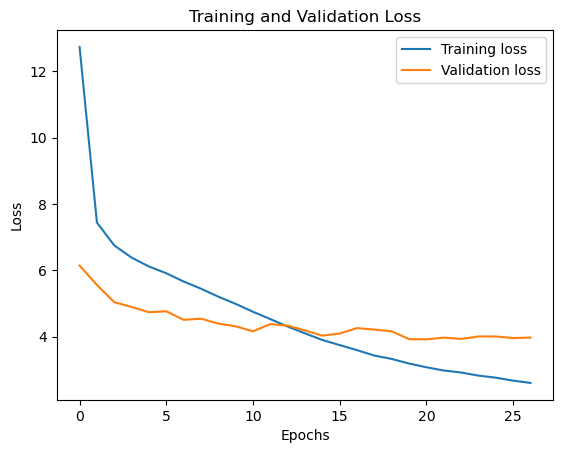

In [59]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [100]:
model_pacific = LSTMModel(input_dim=33, hidden_dim=128, num_layers=1, output_dim=1, dropout = 0.2)
model_pacific.load_state_dict(torch.load('pacific_checkpoint.pt'))
print(model_pacific)

LSTMModel(
  (lstm): LSTM(33, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# Load the trained model and the scaler.
model_pacific.load_state_dict(torch.load('pacific_checkpoint.pt'))
model_pacific.eval()  # Set the model to evaluation mode
model_pacific.to(device)  # Move model to the appropriate device

scaler = joblib.load('pacific_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'pacific_val'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

nse_scores = []  # List to store NSE scores for each catchment

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:

            features_scaled = pacific_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred = model(X_tensor).cpu().numpy()

            # Flatten the predictions and observed values
            y_pred = y_pred.flatten()
            y_observed = y_observed.flatten()

            # Calculate NSE for this catchment
            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}")

# Calculate mean NSE across all catchments
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")


Catchment: hysets_08ME025.csv, NSE: 0.9608642318441182
Catchment: hysets_12037400.csv, NSE: 0.8999349296409573
Catchment: hysets_08HF005.csv, NSE: 0.8920864305605103
Catchment: hysets_14190500.csv, NSE: 0.9161062195171913
Catchment: hysets_14303600.csv, NSE: 0.9245932970822222
Catchment: hysets_12013500.csv, NSE: 0.8973224759623766
Catchment: hysets_12452890.csv, NSE: 0.9684098668489566
Catchment: hysets_12193500.csv, NSE: 0.767349470225908
Catchment: hysets_14111400.csv, NSE: 0.9368775983336483
Catchment: hysets_12488500.csv, NSE: 0.9668568047400469
Catchment: hysets_14179000.csv, NSE: 0.8808033575657721
Catchment: hysets_12155300.csv, NSE: 0.8340145188860264
Catchment: hysets_08ME027.csv, NSE: 0.9501418621206229
Catchment: hysets_12093500.csv, NSE: 0.8668958998621856
Catchment: hysets_12097850.csv, NSE: 0.8118609286925764
Catchment: hysets_08NL024.csv, NSE: 0.978337767167376
Catchment: hysets_08NL071.csv, NSE: 0.9233670725092753
Catchment: hysets_14231900.csv, NSE: 0.9218453517649663

### Test set

This section includes the testing of Pacific model on the two test set. 

Test set (Unseen) includes catchment data that are in the same region, but unseen by the model. 

Test set (Seen) includes catchment data in which first 75% was used to train/ val the model, the latter 25% was placed in this test set.

#### Test set (Unseen, separate set from Pacific)

In [ ]:
# Load the trained model and the scaler
model_pacific.load_state_dict(torch.load('pacific_checkpoint.pt'))
model_pacific.eval()  # Set the model to evaluation mode
model_pacific.to(device)  # Move model to the appropriate device

pacific_scaler = joblib.load('pacific_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'pacific_test'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

test_losses = []
nse_scores = []  # List to store NSE scores for each catchment

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:
            features_scaled = pacific_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_observed, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred_tensor = model_pacific(X_tensor)
            
            # Calculate Loss using tensors directly
            loss = criterion(y_pred_tensor, y_tensor.view(-1, 1))  # Ensure y_tensor is correctly shaped
            test_losses.append(loss.item())

            # Calculate NSE if needed, convert tensors to numpy arrays outside of loss calculation
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_observed = y_tensor.cpu().numpy()

            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}, Loss: {loss.item()}")

# Calculate mean NSE across all catchments
mean_loss = np.mean(test_losses)
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")
print(f"Mean Loss all catchments: {mean_loss}")


Catchment: hysets_12458000.csv, NSE: 0.9311452955007553, Loss: 0.8251416683197021
Catchment: hysets_12041200.csv, NSE: 0.8520712405443192, Loss: 16.090723037719727
Catchment: hysets_12447383.csv, NSE: 0.9751619882881641, Loss: 0.16333694756031036
Catchment: hysets_14118500.csv, NSE: 0.8578541725873947, Loss: 3.5062623023986816
Catchment: hysets_12026400.csv, NSE: 0.871946707367897, Loss: 2.275789499282837
Catchment: hysets_08MH147.csv, NSE: 0.6194373667240143, Loss: 41.99745178222656
Catchment: hysets_12080010.csv, NSE: 0.8973030596971512, Loss: 0.8513545393943787
Catchment: hysets_12452800.csv, NSE: 0.9848365997895598, Loss: 0.08627650141716003
Catchment: hysets_08MA003.csv, NSE: 0.970637708902359, Loss: 0.1719968616962433
Catchment: hysets_14166500.csv, NSE: 0.9291048869490623, Loss: 1.0400738716125488
Catchment: hysets_08MF065.csv, NSE: 0.9299881234765053, Loss: 1.4366118907928467
Catchment: hysets_14306400.csv, NSE: 0.9057286530733109, Loss: 3.8068137168884277
Catchment: hysets_08L

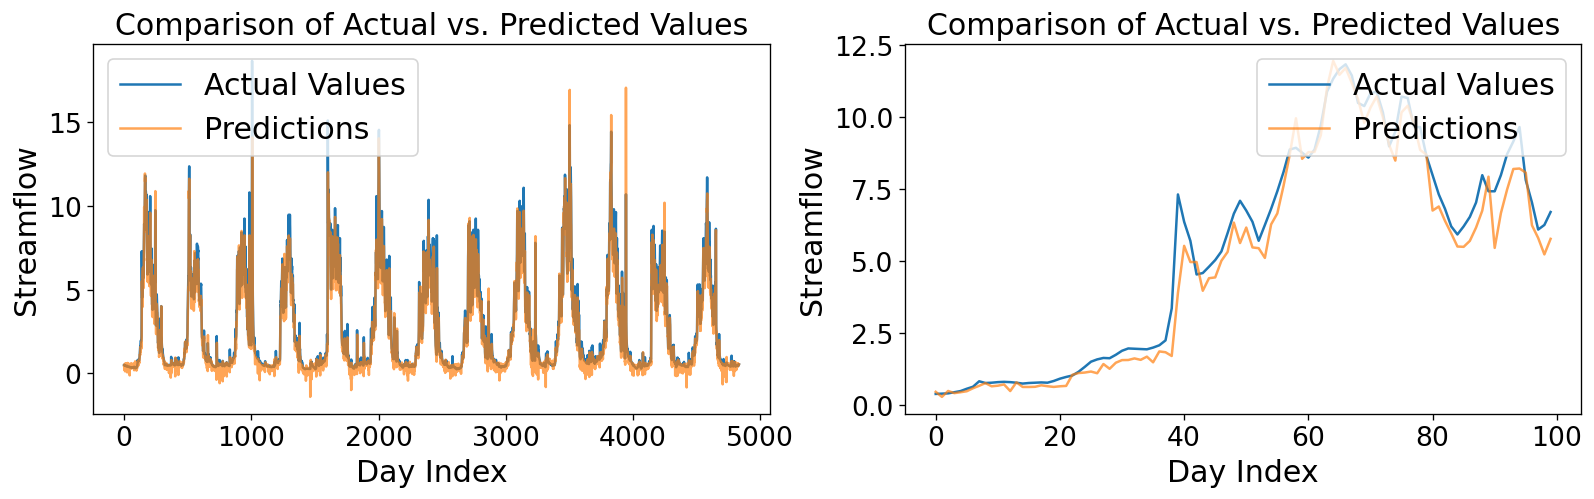

In [105]:
# Create a figure and a subplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=120)

# Plot the lines
ax[0].plot(y_observed, label='Actual Values')
ax[0].plot(y_pred, label='Predictions', alpha=0.7)
ax[1].plot(y_observed[100:200], label='Actual Values')
ax[1].plot(y_pred[100:200], label='Predictions', alpha=0.7)

# Add labels and title
ax[0].set_xlabel('Day Index')
ax[0].set_ylabel('Streamflow')
ax[0].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)
ax[1].set_xlabel('Day Index')
ax[1].set_ylabel('Streamflow')
ax[1].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)

# Set the fontsize for axis labels
ax[0].xaxis.label.set_fontsize(18)
ax[0].yaxis.label.set_fontsize(18)
ax[1].xaxis.label.set_fontsize(18)
ax[1].yaxis.label.set_fontsize(18)

# Increase the size of xticks and yticks
ax[0].tick_params(axis='both', which='both', labelsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=16)

# Add legend and set fontsize
ax[0].legend(fontsize=18, loc='upper left')
ax[1].legend(fontsize=18, loc='upper right')

# Show the plot
plt.savefig('atlantic_compare_15.png', format='png', dpi=300)
plt.show()

#### Test set (Seen, future same watersheds from Pacific)

In [ ]:
# Load the trained model and the scaler
model_pacific.load_state_dict(torch.load('pacific_checkpoint.pt'))
model_pacific.eval()  # Set the model to evaluation mode
model_pacific.to(device)  # Move model to the appropriate device

pacific_scaler = joblib.load('pacific_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'pacific_test_same_hysets'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

test_losses = []
nse_scores = []  # List to store NSE scores for each catchment
best_nse = -float('inf')

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:
            features_scaled = pacific_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_observed, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred_tensor = model_pacific(X_tensor)
            
            # Calculate Loss using tensors directly
            loss = criterion(y_pred_tensor, y_tensor.view(-1, 1))  # Ensure y_tensor is correctly shaped
            test_losses.append(loss.item())

            # Calculate NSE if needed, convert tensors to numpy arrays outside of loss calculation
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_observed = y_tensor.cpu().numpy()

            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}, Loss: {loss.item()}")
                        # Check if this NSE is the best we've seen
            if nse > best_nse:
                best_nse = nse
                best_y_observed = y_observed
                best_y_pred = y_pred

# Calculate mean NSE across all catchments
mean_loss = np.mean(test_losses)
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")
print(f"Mean Loss all catchments: {mean_loss}")
print(f"Best NSE",{best_nse})

Catchment: hysets_14185000.csv, NSE: 0.8962418511509895, Loss: 4.02213716506958
Catchment: hysets_08MH001.csv, NSE: 0.9423053860664368, Loss: 0.6695907115936279
Catchment: hysets_08LB069.csv, NSE: 0.9895347654819489, Loss: 0.06614704430103302
Catchment: hysets_12141300.csv, NSE: 0.8302387297153473, Loss: 14.479601860046387
Catchment: hysets_14171000.csv, NSE: 0.930256612598896, Loss: 1.2406495809555054
Catchment: hysets_12087000.csv, NSE: 0.7824345380067825, Loss: 4.511767864227295
Catchment: hysets_14201340.csv, NSE: 0.9630060158669949, Loss: 0.4047783315181732
Catchment: hysets_08LG048.csv, NSE: 0.959175955504179, Loss: 0.3060302138328552
Catchment: hysets_12488500.csv, NSE: 0.9414167366921902, Loss: 0.6153572797775269
Catchment: hysets_08ME027.csv, NSE: 0.9352823719382286, Loss: 1.2062031030654907
Catchment: hysets_08GA075.csv, NSE: 0.7869459092617035, Loss: 7.361117839813232
Catchment: hysets_12189500.csv, NSE: 0.8961286097764969, Loss: 2.3402302265167236
Catchment: hysets_08HA001.

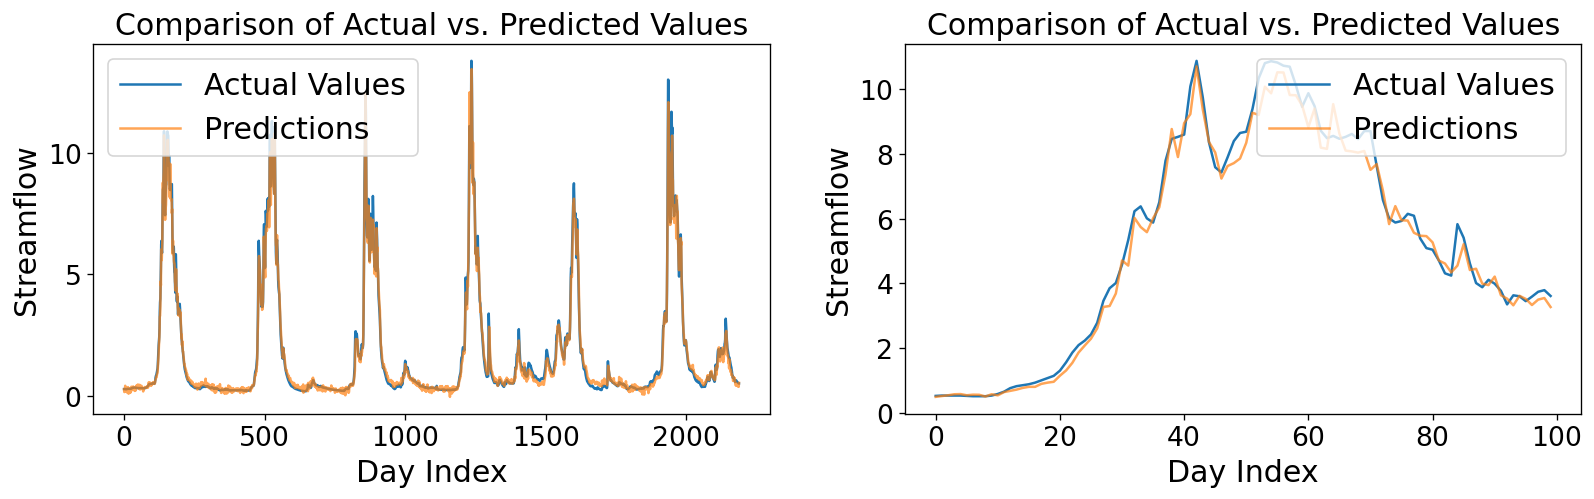

In [120]:
# Create a figure and a subplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=120)

# Plot the lines
ax[0].plot(best_y_observed, label='Actual Values')
ax[0].plot(best_y_pred, label='Predictions', alpha=0.7)
ax[1].plot(best_y_observed[100:200], label='Actual Values')
ax[1].plot(best_y_pred[100:200], label='Predictions', alpha=0.7)

# Add labels and title
ax[0].set_xlabel('Day Index')
ax[0].set_ylabel('Streamflow')
ax[0].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)
ax[1].set_xlabel('Day Index')
ax[1].set_ylabel('Streamflow')
ax[1].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)

# Set the fontsize for axis labels
ax[0].xaxis.label.set_fontsize(18)
ax[0].yaxis.label.set_fontsize(18)
ax[1].xaxis.label.set_fontsize(18)
ax[1].yaxis.label.set_fontsize(18)

# Increase the size of xticks and yticks
ax[0].tick_params(axis='both', which='both', labelsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=16)

# Add legend and set fontsize
ax[0].legend(fontsize=18, loc='upper left')
ax[1].legend(fontsize=18, loc='upper right')

# Show the plot
plt.savefig('atlantic_compare_15.png', format='png', dpi=300)
plt.show()

### Cross Region (Pacific model tested on Atlantic data)

In [ ]:
# Load the trained model and the scaler
model_pacific.load_state_dict(torch.load('pacific_checkpoint.pt'))
model_pacific.eval()  # Set the model to evaluation mode
model_pacific.to(device)  # Move model to the appropriate device

pacific_scaler = joblib.load('pacific_standardscaler.joblib')

# Prepare the dataset for validation
folder = 'atlantic_test'
folder_path = f'data/{folder}'
seq_length = 5  # Number of days to look back

test_losses = []
nse_scores = []  # List to store NSE scores for each catchment

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)
        df.dropna(subset=['streamflow'], inplace=True)  # Drop NaN streamflow values

        if len(df) > seq_length:

            features_scaled = pacific_scaler.transform(df)
            # Create sequences for the LSTM
            X, y_observed = create_sequences(features_scaled, df['streamflow'].values, seq_length)

            # Convert sequences to tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_observed, dtype=torch.float32).to(device)

            # Get predictions from the model
            with torch.no_grad():
                y_pred_tensor = model_pacific(X_tensor)
            
            # Calculate Loss using tensors directly
            loss = criterion(y_pred_tensor, y_tensor.view(-1, 1))  # Ensure y_tensor is correctly shaped
            test_losses.append(loss.item())

            # Calculate NSE if needed, convert tensors to numpy arrays outside of loss calculation
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_observed = y_tensor.cpu().numpy()

            nse = calculate_nse(y_observed, y_pred)
            nse_scores.append(nse)
            print(f"Catchment: {file}, NSE: {nse}, Loss: {loss.item()}")

# Calculate mean NSE across all catchments
mean_loss = np.mean(test_losses)
mean_nse = np.mean(nse_scores)
print(f"Mean NSE across all catchments: {mean_nse}")
print(f"Mean Loss all catchments: {mean_loss}")


Catchment: hysets_02353265.csv, NSE: -0.17918896675109863, Loss: 1.9374953508377075
Catchment: hysets_02370000.csv, NSE: 0.21677559614181519, Loss: 6.334216117858887
Catchment: hysets_02413000.csv, NSE: 0.5654959976673126, Loss: 2.4774138927459717
Catchment: hysets_02374700.csv, NSE: 0.023290932178497314, Loss: 3.5090529918670654
Catchment: hysets_02207448.csv, NSE: 0.3204221725463867, Loss: 2.0781562328338623
Catchment: hysets_03567500.csv, NSE: 0.637672632932663, Loss: 3.212820529937744
Catchment: hysets_02220900.csv, NSE: -6.0558319091796875e-05, Loss: 2.6026644706726074
Catchment: hysets_02329500.csv, NSE: 0.3467176556587219, Loss: 3.3857133388519287
Catchment: hysets_02331600.csv, NSE: 0.04029315710067749, Loss: 3.697974920272827
Catchment: hysets_02427250.csv, NSE: 0.5290502607822418, Loss: 4.738004207611084
Catchment: hysets_02338660.csv, NSE: 0.3894577622413635, Loss: 2.2663414478302
Catchment: hysets_02344500.csv, NSE: 0.43750905990600586, Loss: 2.6423754692077637
Catchment: h

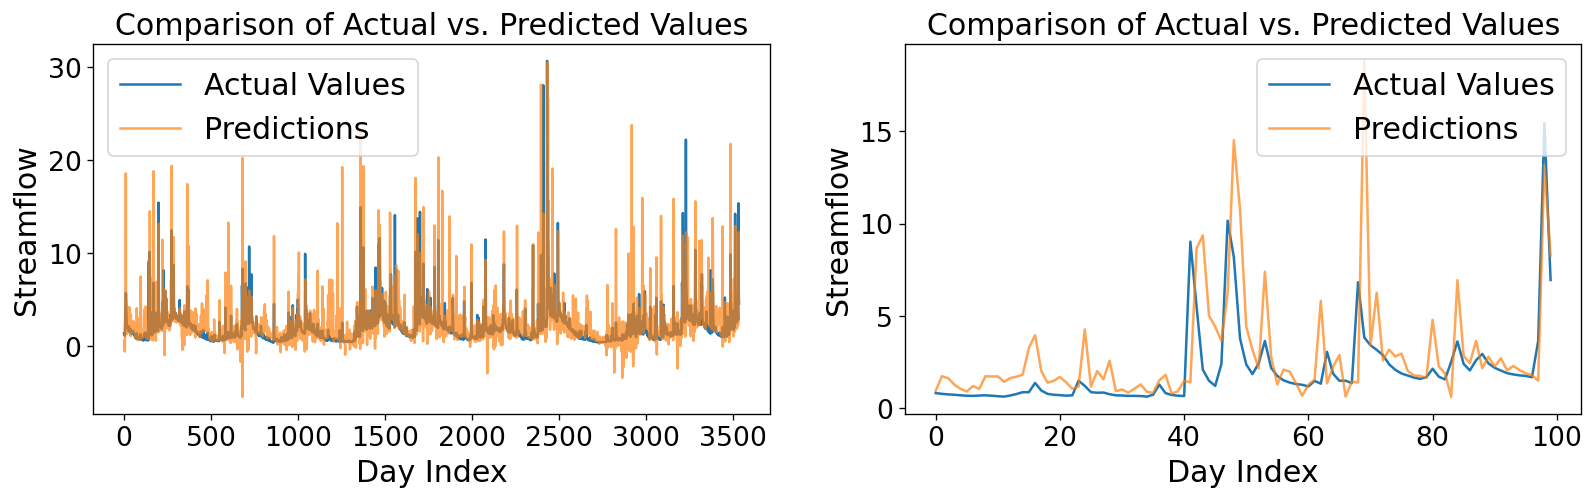

In [111]:
# Create a figure and a subplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=120)

# Plot the lines
ax[0].plot(y_observed, label='Actual Values')
ax[0].plot(y_pred, label='Predictions', alpha=0.7)
ax[1].plot(y_observed[100:200], label='Actual Values')
ax[1].plot(y_pred[100:200], label='Predictions', alpha=0.7)

# Add labels and title
ax[0].set_xlabel('Day Index')
ax[0].set_ylabel('Streamflow')
ax[0].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)
ax[1].set_xlabel('Day Index')
ax[1].set_ylabel('Streamflow')
ax[1].set_title('Comparison of Actual vs. Predicted Values', fontsize=18)

# Set the fontsize for axis labels
ax[0].xaxis.label.set_fontsize(18)
ax[0].yaxis.label.set_fontsize(18)
ax[1].xaxis.label.set_fontsize(18)
ax[1].yaxis.label.set_fontsize(18)

# Increase the size of xticks and yticks
ax[0].tick_params(axis='both', which='both', labelsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=16)

# Add legend and set fontsize
ax[0].legend(fontsize=18, loc='upper left')
ax[1].legend(fontsize=18, loc='upper right')

# Show the plot
plt.savefig('atlantic_compare_15.png', format='png', dpi=300)
plt.show()

The model performance on streamflow predictions within Pacific region is very good, with NSE as high as 0.89. However, the model also failed to handle cross region data set when tested with Atlantic data.